# 工业蒸汽量预测  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import warnings
warnings.filterwarnings("ignore")


### 合并训练集与测试集

In [2]:
train = pd.read_csv('data/zhengqi_train.txt', sep = '\t')
test = pd.read_csv('data/zhengqi_test.txt', sep = '\t')

train['origin'] = 1
test['origin'] = 0
data = pd.concat([train, test], axis = 0)
data.head(5)

,V0,V1,V10,V11,V12,V13,V14,V15,V16,V17,...,V36,V37,V4,V5,V6,V7,V8,V9,origin,target
0,0.566,0.016,-0.940,-0.307,-0.073,0.550,-0.484,0.000,-1.707,-1.162,...,-2.608,-3.508,0.452,-0.901,-1.812,-2.360,-0.436,-2.114,1,0.175
1,0.968,0.437,0.188,-0.455,-0.134,1.109,-0.488,0.000,-0.977,-1.162,...,-0.335,-0.730,0.194,-0.893,-1.566,-2.360,0.332,-2.114,1,0.676
2,1.013,0.568,0.874,-0.051,-0.072,0.767,-0.493,-0.212,-0.618,-0.897,...,0.765,-0.589,0.112,-0.797,-1.367,-2.360,0.396,-2.114,1,0.633
3,0.733,0.368,0.011,0.102,-0.014,0.769,-0.371,-0.162,-0.429,-0.897,...,0.333,-0.112,0.599,-0.679,-1.200,-2.086,0.403,-2.114,1,0.206
4,0.684,0.638,-0.251,0.570,0.199,-0.349,-0.342,-0.138,-0.391,-0.897,...,-0.280,-0.028,0.337,-0.454,-1.073,-2.086,0.314,-2.114,1,0.384


### 查看数据分布

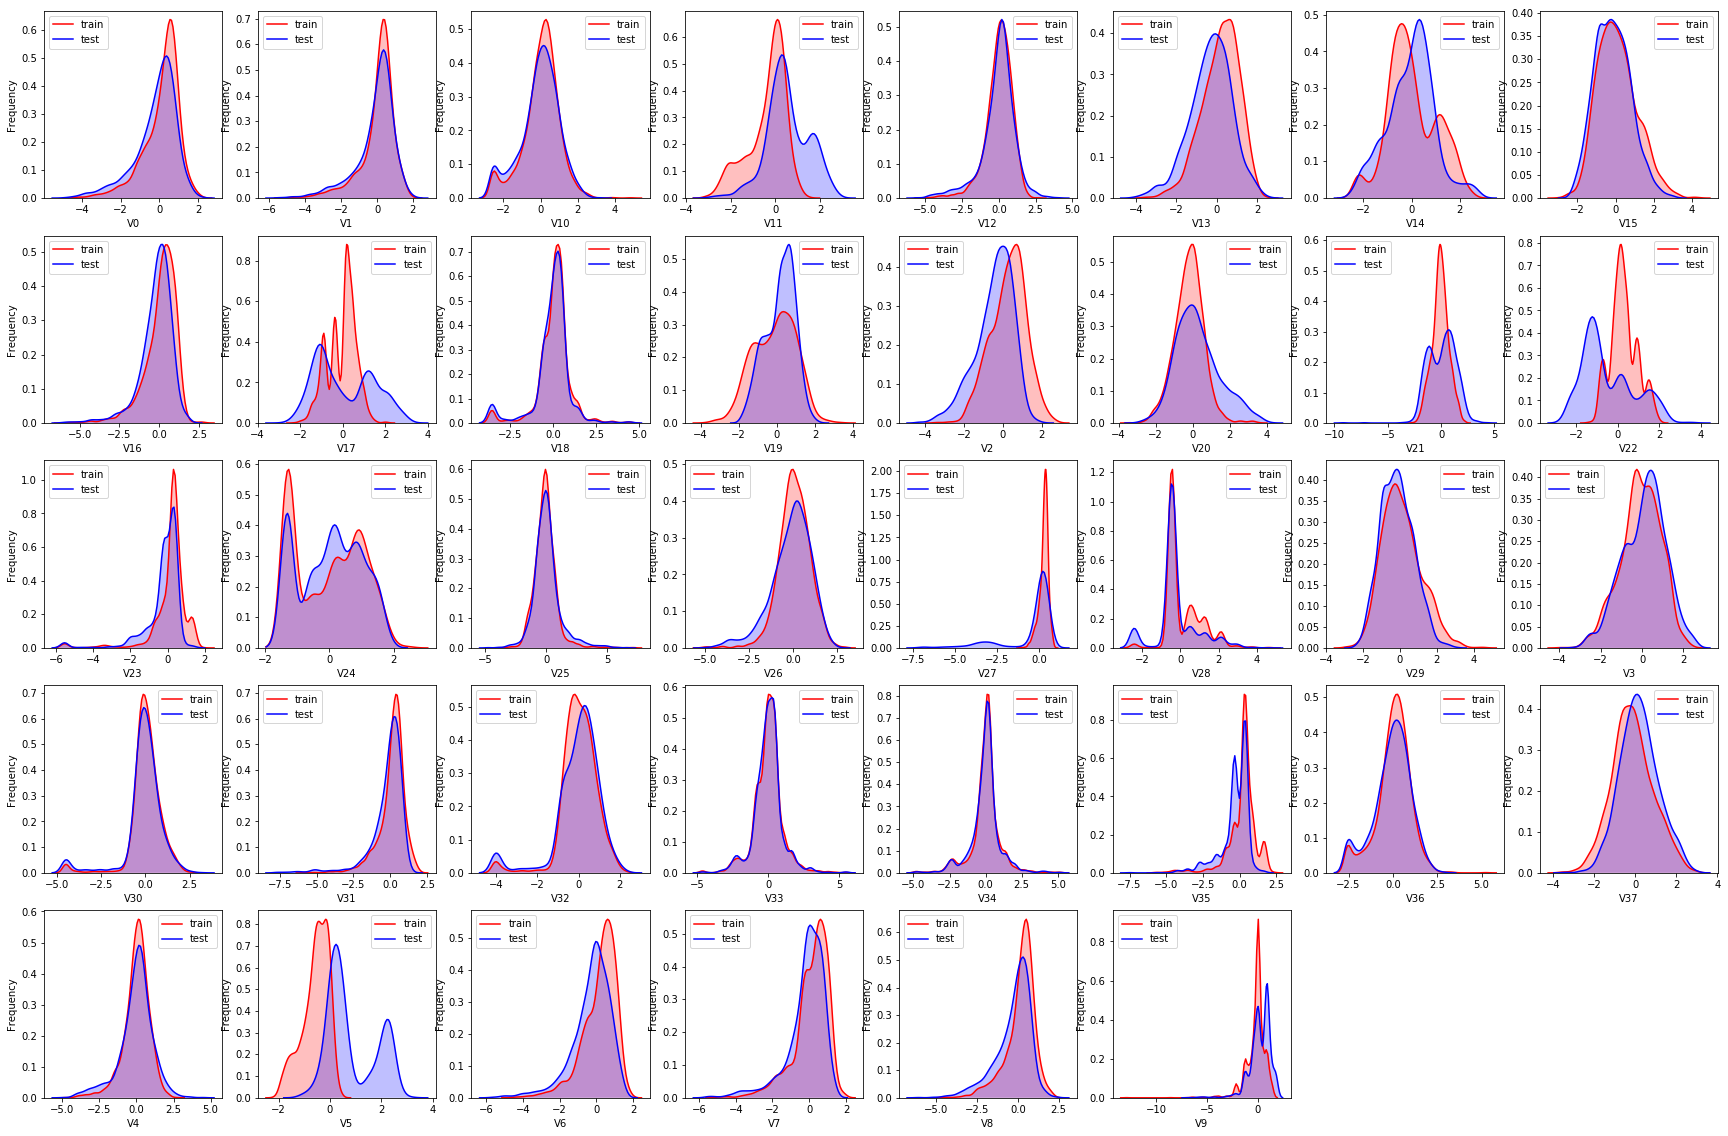

In [3]:
fig = plt.subplots(figsize = (30,20))
j = 1
for column in data.columns[0:-2]:
    plt.subplot(5,8,j)
    g = seaborn.kdeplot(data[data.origin == 1][column], color = 'Red', shade = True)
    g = seaborn.kdeplot(data[data.origin == 0][column], color = 'Blue', shade = True)
    g.set_xlabel(column)
    g.set_ylabel('Frequency')
    g = g.legend(['train', 'test'])
    j += 1
plt.show()
    

从训练集和测试集的数据分布来说，特征'V2','V5','V9','V11','V13','V14','V17','V19', 'V20','V21','V22','V27','V35'的分布不一致，做剔除操作。
### 剔除特征

In [4]:
data.drop(['V2', 'V5', 'V9', 'V11', 'V13', 'V14', 'V17', 'V19', 'V20', 'V21', 'V22', 'V27', 'V35'],axis=1,inplace=True)
data_train = data[data.origin == 1].drop(['origin'], axis=1)

### 查看特征间相关系数  

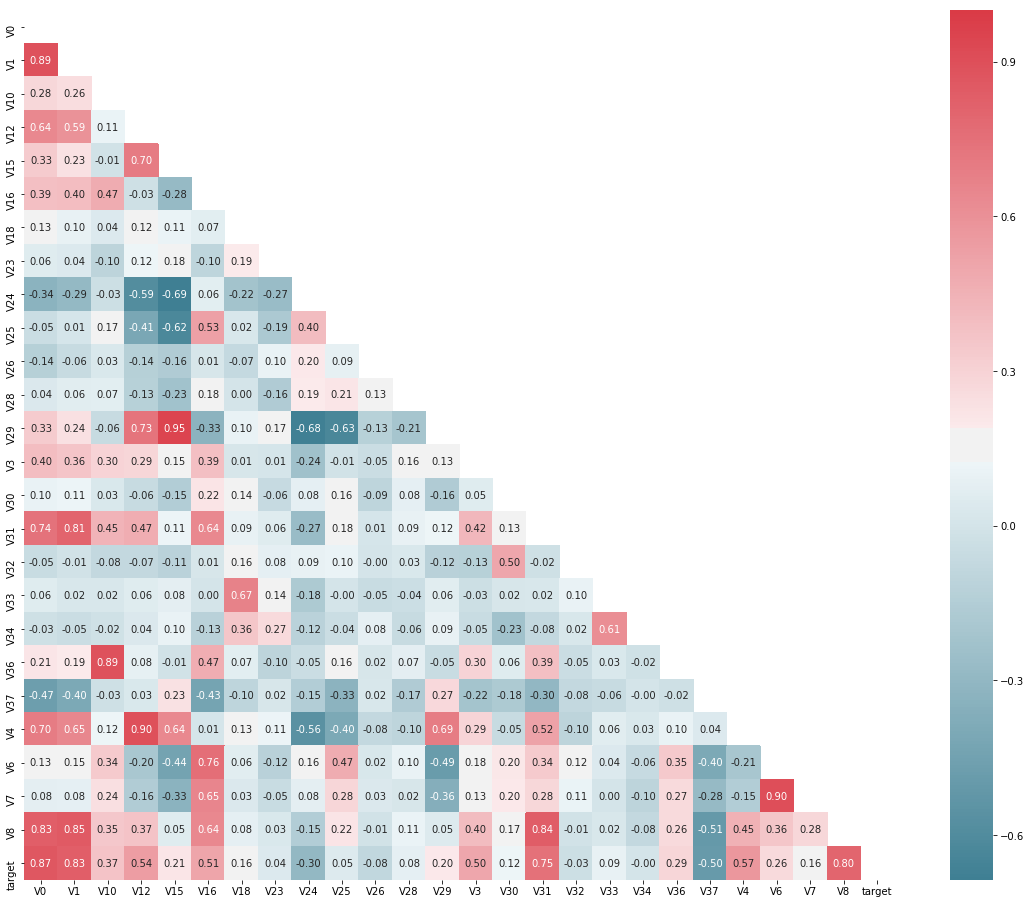

In [5]:
plt.figure(figsize = (20, 16))
colnm = data_train.columns.tolist()
mcorr = data_train[colnm].corr(method = 'spearman')
mask = np.zeros_like(mcorr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = seaborn.diverging_palette(220, 10, as_cmap = True)
g = seaborn.heatmap(mcorr, mask = mask, cmap=cmap, square=True, annot=True, fmt='0.2f')
plt.show()

### 设置相关系数阈值,剔除与target相关系数小于阈值的特征  

In [6]:
threshold = 0.1
corr_matrix = data_train.corr().abs()
drop_col = corr_matrix[corr_matrix['target'] < threshold].index
data.drop(drop_col, axis = 1, inplace=True)
print drop_col


Index([u'V25', u'V26', u'V32', u'V33', u'V34'], dtype='object')


### 数据基本统计  

In [7]:
cols_numeric = list(data.columns)
cols_numeric.remove('origin')
def scale_minmax(col):
    return 1.0 * (col-col.min())/(col.max()-col.min())
scale_cols = [col for col in cols_numeric if col != 'target']
data[scale_cols] = data[scale_cols].apply(scale_minmax, axis=0)
data[scale_cols].describe()

,V0,V1,V10,V12,V15,V16,V18,V23,V24,V28,V29,V3,V30,V31,V36,V37,V4,V6,V7,V8
count,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000
mean,0.694172,0.721357,0.348518,0.578507,0.402251,0.679294,0.446542,0.744438,0.356712,0.342653,0.388683,0.603139,0.589459,0.792709,0.332385,0.545795,0.523743,0.748823,0.745740,0.715607
std,0.144198,0.131443,0.134882,0.105088,0.138561,0.112095,0.124627,0.134085,0.265512,0.140731,0.133475,0.152462,0.130786,0.102976,0.127456,0.150356,0.106430,0.132560,0.132577,0.118105
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.626676,0.679416,0.284327,0.532892,0.299016,0.629414,0.399302,0.719362,0.040616,0.278778,0.292445,0.503888,0.550092,0.761816,0.270584,0.445647,0.478182,0.683324,0.696938,0.664934
50%,0.729488,0.752497,0.366469,0.591635,0.391437,0.700258,0.456256,0.788817,0.381736,0.279904,0.375734,0.614270,0.594428,0.815055,0.347056,0.539317,0.535866,0.774125,0.771974,0.742884
75%,0.790195,0.799553,0.432965,0.641971,0.489954,0.753279,0.501745,0.792706,0.574728,0.413031,0.471837,0.710474,0.650798,0.852229,0.414861,0.643061,0.585036,0.842259,0.836405,0.790835
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 检查Box-Cox变换对连续变量分布的影响  

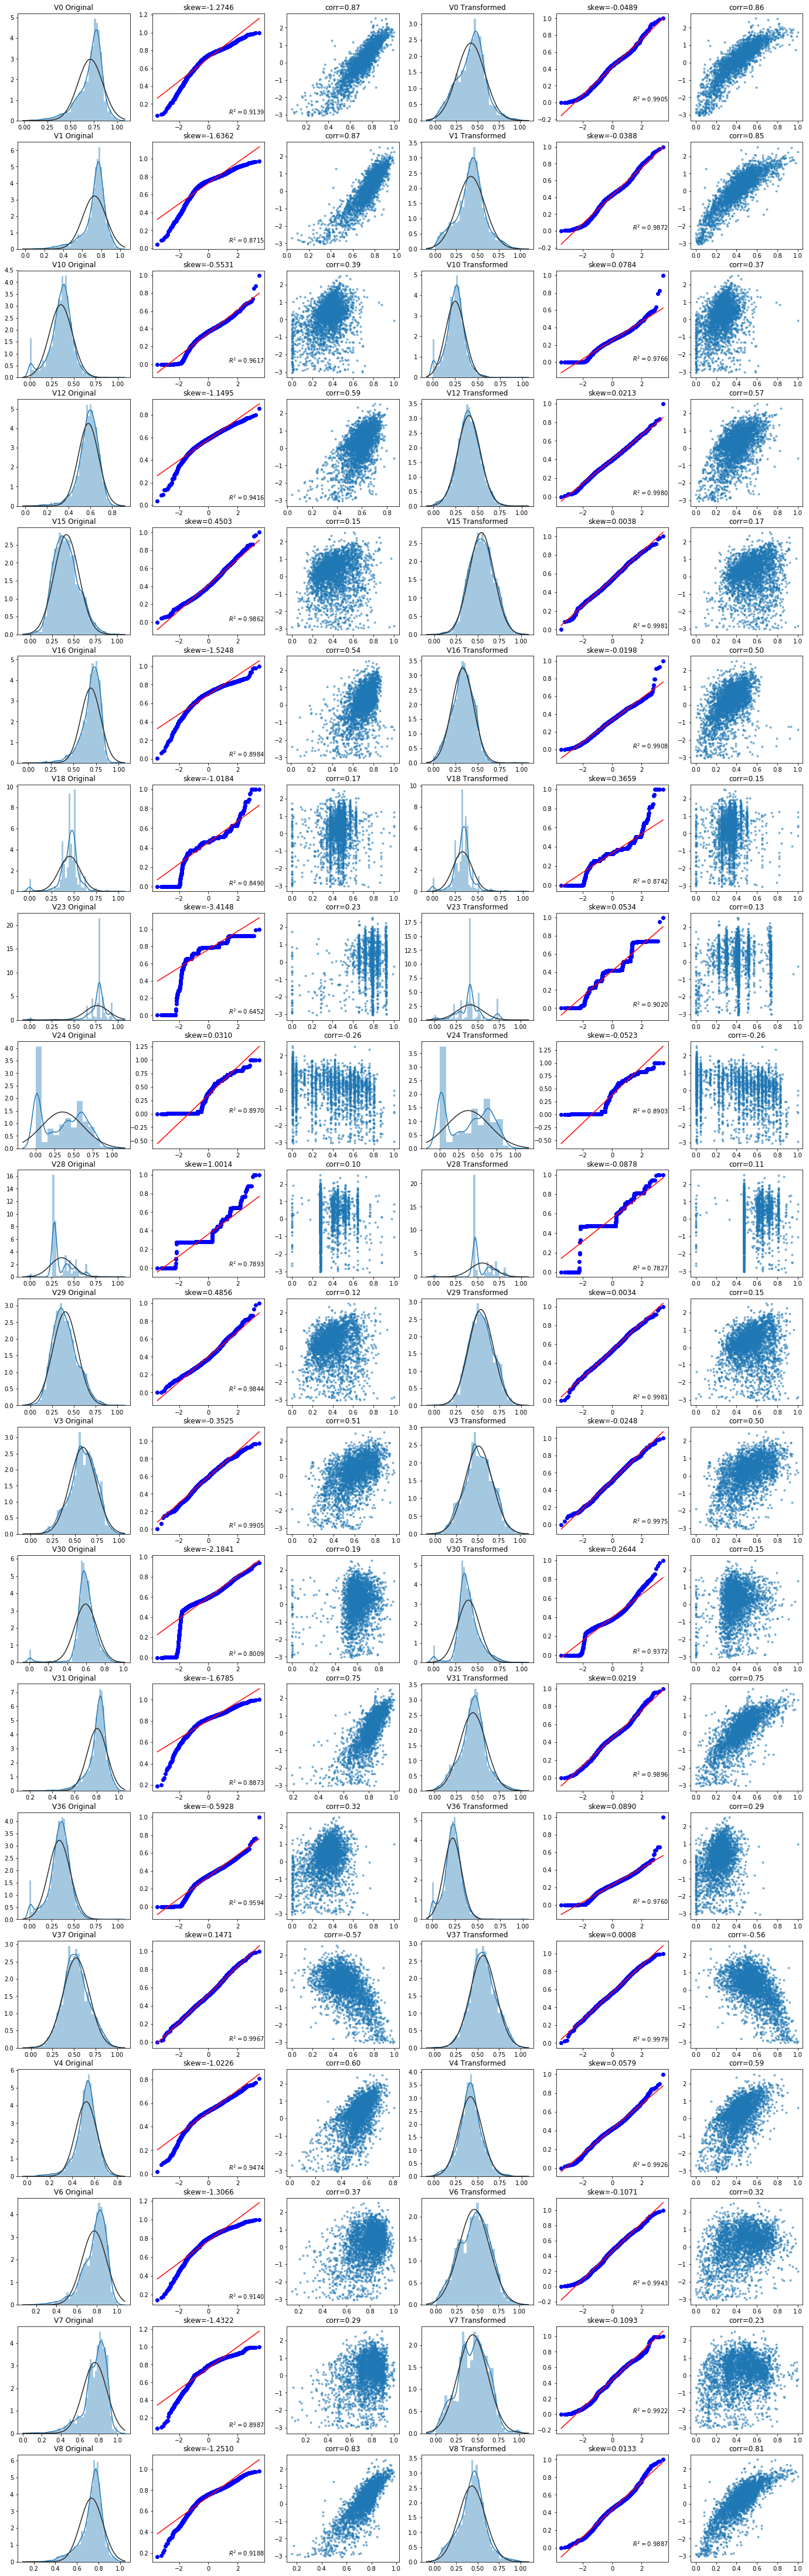

In [10]:
from scipy import stats
fcols = 6
frows = len(cols_numeric) - 1
plt.figure(figsize = (4 * fcols, 4 * frows))
i = 0
for var in cols_numeric:
    if var != 'target':
        #原始数据
        dat = data[[var, 'target']].dropna()
        i += 1
        plt.subplot(frows, fcols, i)
        seaborn.distplot(dat[var], fit = stats.norm)
        plt.title(var + ' Original')
        plt.xlabel('')
        
        #计算偏度
        i += 1
        plt.subplot(frows, fcols, i)
        _ = stats.probplot(dat[var], plot=plt)
        plt.title('skew=' + '{:.4f}'.format(stats.skew(dat[var])))
        plt.xlabel('')
        plt.ylabel('')
        
        #相关系数
        i += 1
        plt.subplot(frows, fcols, i)
        plt.plot(dat[var], dat['target'], '.', alpha=0.5)
        plt.title('corr=' + '{:.2f}'.format(np.corrcoef(dat[var], dat['target'])[0][1]))
        
        # Box-Cox变换
        """
        广义幂变换方法，用于连续的响应变量不满足正态分布的情况
        Box-Cox变换之后，可以一定程度上减小不可观测的误差和预测变量的相关性
        Box-Cox变换的主要特点是引入一个参数，通过数据本身估计该参数进而确定应采取的数据变换形式，
        Box-Cox变换可以明显地改善数据的正态性、对称性和方差相等性
        """
        i += 1
        plt.subplot(frows, fcols, i)
        trans_var, lambda_var = stats.boxcox(dat[var].dropna() + 1)
        trans_var = scale_minmax(trans_var)
        seaborn.distplot(trans_var, fit = stats.norm)
        plt.title(var + ' Transformed')
        plt.xlabel('')
        
        #计算变换后的偏度
        i += 1
        plt.subplot(frows, fcols, i)
        _ = stats.probplot(trans_var, plot=plt)
        plt.title('skew=' + '{:.4f}'.format(stats.skew(trans_var)))
        plt.xlabel('')
        plt.ylabel('')
        
        #计算变换后的相关系数
        i += 1
        plt.subplot(frows, fcols, i)
        plt.plot(trans_var, dat['target'], '.', alpha=0.5)
        plt.title('corr=' + '{:.2f}'.format(np.corrcoef(trans_var, dat['target'])[0][1]))
plt.show()

### 用Box-Cox变换后的特征替换原特征

In [12]:
for var in cols_numeric:
    if var != 'target':
        trans_var, lambda_var = stats.boxcox(data[var].dropna() + 1)
        trans_var = scale_minmax(trans_var)
        data[var] = trans_var
data.tail(5)
        

,V0,V1,V10,V12,V15,V16,V18,V23,V24,V28,...,V30,V31,V36,V37,V4,V6,V7,V8,origin,target
1920,0.174567,0.136669,0.002347,0.375340,0.658050,0.009564,0.000652,0.126486,0.212163,0.513340,...,0.000521,0.007425,0.002751,0.662029,0.363811,0.011150,0.002340,0.034219,0,NaN
1921,0.069723,0.033867,0.004207,0.167267,0.690671,0.002447,0.219190,0.131795,0.332399,0.365589,...,0.257653,0.000000,0.002751,0.750500,0.195275,0.009874,0.004546,0.025936,0,NaN
1922,0.074439,0.030625,0.003920,0.217328,0.611734,0.015434,0.159826,0.172312,0.666522,0.365428,...,0.355643,0.005370,0.004011,0.806457,0.204441,0.024894,0.015623,0.010391,0,NaN
1923,0.071801,0.028388,0.001705,0.187908,0.571733,0.026132,0.187303,0.172427,0.600740,0.365428,...,0.515597,0.011978,0.003696,0.781028,0.204605,0.040231,0.026534,0.018475,0,NaN
1924,0.092821,0.047983,0.242441,0.217072,0.571733,0.031827,0.194115,0.171968,0.600481,0.366234,...,0.238888,0.012576,0.108284,0.858855,0.235230,0.043802,0.028131,0.026537,0,NaN


### Log转换因变量提高常态

In [14]:
data['target_log'] = np.power(1.5, data['target'])
data.head(5)

,V0,V1,V10,V12,V15,V16,V18,V23,V24,V28,...,V31,V36,V37,V4,V6,V7,V8,origin,target,target_log
0,0.492078,0.342925,0.137530,0.321589,0.542959,0.132823,0.260717,0.423630,0.600740,0.364945,...,0.260643,0.000000,0.020876,0.371781,0.153082,0.085051,0.297903,1,0.175,1.073534
1,0.596032,0.430055,0.257630,0.314989,0.542959,0.193188,0.260935,0.423879,0.600998,0.534162,...,0.369186,0.179417,0.465871,0.343284,0.176903,0.085051,0.423388,1,0.676,1.315339
2,0.608715,0.460792,0.341557,0.321698,0.512328,0.230061,0.261698,0.423382,0.642075,0.618437,...,0.419866,0.295829,0.487147,0.334492,0.198267,0.085051,0.435564,1,0.633,1.292605
3,0.533283,0.414590,0.237332,0.328057,0.519649,0.251664,0.260608,0.422637,0.761398,0.619891,...,0.420305,0.247660,0.558335,0.388593,0.217764,0.102706,0.436914,1,0.206,1.087113
4,0.520910,0.477982,0.208291,0.352105,0.523141,0.256201,0.260826,0.422637,0.621589,0.618701,...,0.431171,0.184755,0.570750,0.358921,0.233612,0.102706,0.420015,1,0.384,1.168474


### 查看经box-cox和特征选择之后的分布

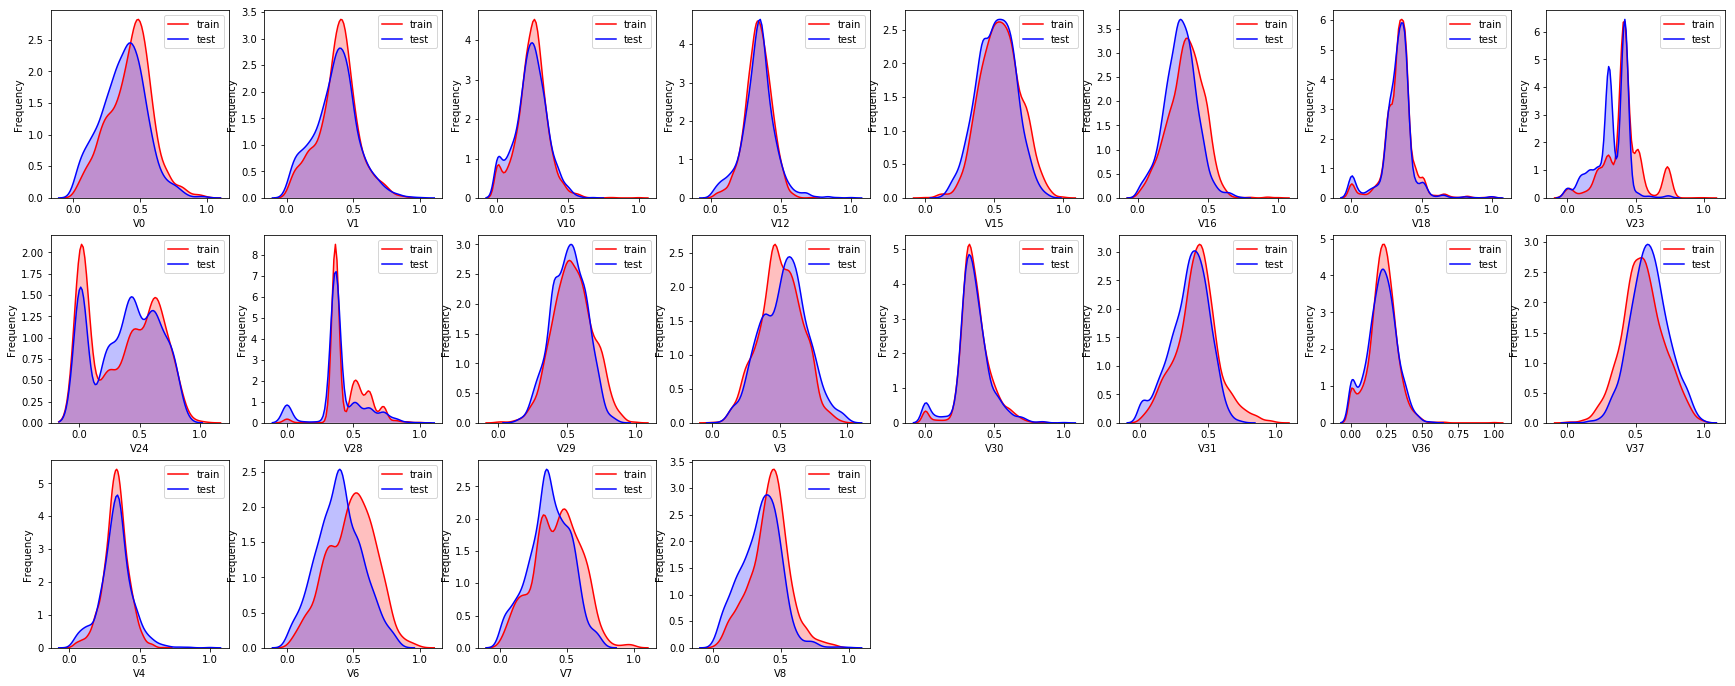

In [17]:
fig = plt.subplots(figsize = (30,20))
j = 1
for col in data.columns[0:-3]:
    plt.subplot(5,8,j)
    g = seaborn.kdeplot(data[data.origin == 1][col], color='Red', shade = True)
    g = seaborn.kdeplot(data[data.origin == 0][col], color='Blue', shade = True )
    g.set_xlabel(col)
    g.set_ylabel('Frequency')
    g = g.legend(['train', 'test'])
    j += 1
plt.show()

### 工具函数

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score,cross_val_predict,KFold
from sklearn.metrics import make_scorer,mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler,StandardScaler

#获取训练验证集
def get_training_data():
    df_train = data[data.origin == 1]
    X = df_train.drop(['origin', 'target', 'target_log'], axis = 1)
    y = df_train.target_log
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, random_state = 100)
    return X_train, X_valid, y_train, y_valid

#获取测试集
def get_test_data():
    df_test = data[data.origin == 0]
    return df_test.drop(['origin', 'target', 'target_log'], axis = True)

#均方根误差
def rmse(y_true, y_pred):
    diff = y_pred - y_true
    sum_sp = sum(diff ** 2)
    n = len(y_pred)
    return np.sqrt(1.0 * sum_sp / n)

#均方误差
def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

rmse_scorer = make_scorer(rmse, greater_is_better=False)
mse_scorer = make_scorer(mse, greater_is_better=False)

#根据模型检查离群点
def find_outliers(model, X, y, sigma=3):
    try:
        y_pred = pd.Series(model.predict(X), index=y.index)
    except:
        model.fit(X,y)
        y_pred = pd.Series(model.predict(X), index=y.index)
    
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
    
    z = (resid - mean_resid) / std_resid #残差的正太性检验
    outliers = z[abs(z) > sigma].index
    
    print 'R2=', model.score(X,y)
    print 'rmse=', rmse(y, y_pred)
    print 'mse=', mean_squared_error(y, y_pred)
    print '---------------------------------------'
    print 'mean of residuals:', mean_resid
    print 'std of residuals:', std_resid
    print '---------------------------------------'
    print len(outliers), 'outliers:'
    print outliers.tolist()
    
    #绘图
    plt.figure(figsize=(15,5))
    ax_131 = plt.subplot(1,3,1)
    plt.plot(y, y_pred, '.')
    plt.plot(y.loc[outliers], y_pred.loc[outliers], 'ro')
    plt.legend(['Accepted', 'Outlier'])
    plt.xlabel('y')
    plt.ylabel('y_pred')
    
    ax_132 = plt.subplot(1,3,2)
    plt.plot(y,y-y_pred,'.')
    plt.plot(y.loc[outliers], y.loc[outliers]-y_pred.loc[outliers], 'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y-y_pred')
    
    ax_133 = plt.subplot(1,3,3)
    z.plot.hist(bins=50, ax=ax_133)
    z.loc[outliers].plot.hist(color='r', bins=50, ax=ax_133)
    plt.legend(['Accepted', 'Outlier'])
    plt.xlabel('z')
    
    plt.savefig('outliers.png')
    
    return outliers


### 分割数据，发现删除离群点

R2= 0.8483810247908671
rmse= 0.15362805300232574
mse= 0.023601578669285465
---------------------------------------
mean of residuals: 3.867377582068828e-17
std of residuals: 0.15366607504300273
---------------------------------------
24 outliers:
[1297, 2824, 1164, 1304, 1296, 2697, 1903, 2211, 1921, 1874, 776, 848, 2696, 2668, 1310, 1901, 1412, 1979, 1488, 1458, 2769, 674, 1932, 2669]


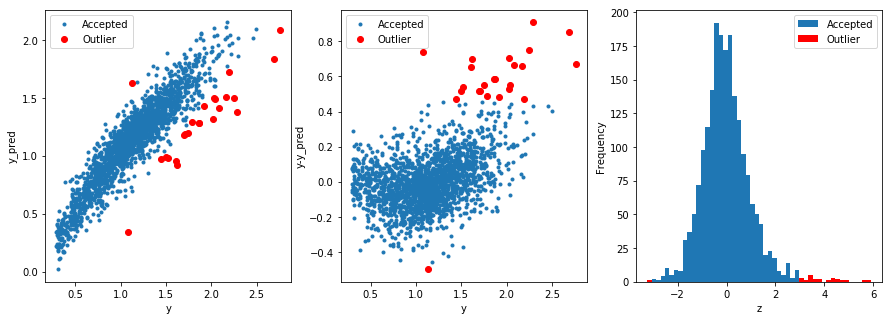

In [28]:
X_train, X_valid, y_train, y_valid = get_training_data()
test = get_test_data()

outliers = find_outliers(Ridge(), X_train, y_train)

X_outliers = X_train.loc[outliers]
y_outliers = y_train.loc[outliers]
X_t = X_train.drop(outliers)
y_t = y_train.drop(outliers)

In [29]:
#获取剔除异常值后的训练集
def get_trainning_data_omitoutlierd():
    y1 = y_t.copy()
    X1 = X_t.copy()
    return X1, y1

#训练模型
def train_model(model, param_grid=[], X=[], y = [], splits=5, repeats = 5):
    if len(y) == 0:
        X, y = get_trainning_data_omitoutlierd()
    #交叉验证
    rkfold = RepeatedKFold(n_splits=splits, n_repeats=repeats) # p次k折交叉验证
    #如果param_grid给出则进行网格搜索
    if len(param_grid) > 0:
        #设置搜索参数
        #GridSearchCV()在指定范围内自动搜索具有不同超参数的不同模型组合，自动选择输入参数中的最优组合
        gsearch = GridSearchCV(model, param_grid, cv=rkfold,
                              scoring='neg_mean_squared_error',
                              verbose=1, return_train_score=True
                              )
        #评估模型
        gsearch.fit(X,y)
        #选择最佳模型
        model = gsearch.best_estimator_
        best_idx = gsearch.best_index_
        #获取最佳模型的cv-scores
        grid_results = pd.DataFrame(gsearch.cv_results_)
        cv_mean = abs(grid_results.loc[best_idx, 'mean_test_score'])
        cv_std = grid_results.loc[best_idx, 'std_test_score'] # loc:按索引值定位
    else:
        grid_results = []
        cv_results = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=rkfold)  # 交叉验证
        cv_mean = abs(np.mean(cv_results)) # 均值
        cv_std = np.std(cv_results) # 标准差
        
    cv_score = pd.Series({'mean':cv_mean, 'std':cv_std})
    y_pred = model.predict(X)
    #输出需要统计的数据
    print '---------------------------'
    print model
    print '---------------------------'
    print 'score=', model.score(X,y)
    print 'rmse=', rmse(y, y_pred)
    print 'mse=', mse(y, y_pred)
    print 'cross_val:mean=', cv_mean, ', std=', cv_std
    
    #绘图 
    y_pred = pd.Series(y_pred, index=y.index)
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
    z = (resid - mean_resid) / std_resid
    n_outliers = sum(abs(z) > 3)
    
    plt.figure(figsize=(15,5))
    ax_131 = plt.subplot(1,3,1)
    plt.plot(y, y_pred, '.')
    plt.xlabel('y')
    plt.ylabel('y_pred')
    plt.title('corr = {:.3f}'.format(np.corrcoef(y, y_pred)[0][1]))
    ax_132 = plt.subplot(1,3,2)
    plt.plot(y, y-y_pred, '.')
    plt.xlabel('y')
    plt.ylabel('y - y_pred')
    plt.title('std resid = {:.3f}'.format(std_resid))
    
    ax_133 = plt.subplot(1,3,3)
    z.plot.hist(bins=50, ax=ax_133)
    plt.xlabel('z')
    plt.title('{:.0f} sample with z>3'.format(n_outliers))
    
    return model, cv_score, grid_results


In [30]:
opt_models = {}
score_models = pd.DataFrame(columns=['mean', 'std'])

splits = 5
repeats = 5


Fitting 25 folds for each of 24 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   18.7s finished


---------------------------
LinearSVR(C=2.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)
---------------------------
score= 0.8686729497459098
rmse= 0.13975223629354444
mse= 0.01953068754904669
cross_val:mean= 0.019721055527916552 , std= 0.001874484695131654


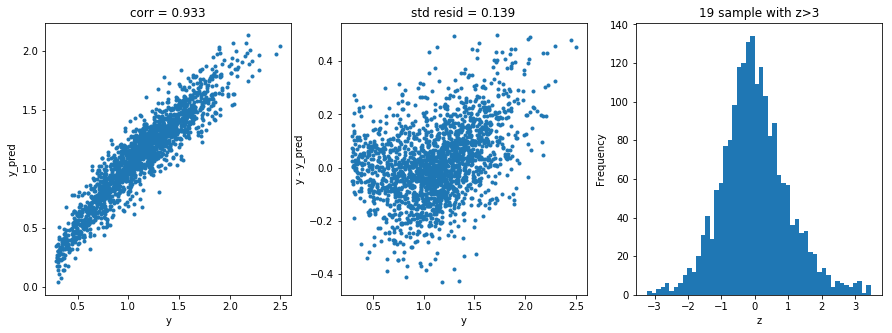

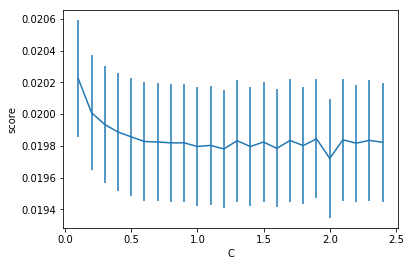

In [36]:
model = 'LinearSVR'
opt_models[model] = LinearSVR()

crange = np.arange(0.1,2.5,0.1)
param_grid = {'C':crange,
              'max_iter':[1000]}
# 训练模型
opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid,
                                                       splits=splits, repeats=repeats)
cv_score.name = model
score_models = score_models.append(cv_score)
plt.figure()
plt.errorbar(crange, abs(grid_results['mean_test_score']), abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('C')
plt.ylabel('score')
plt.show()

In [37]:
test_pred = opt_models[model].predict(test)
pd.Series(test_pred).to_csv('submit.txt', index=None, header=None)